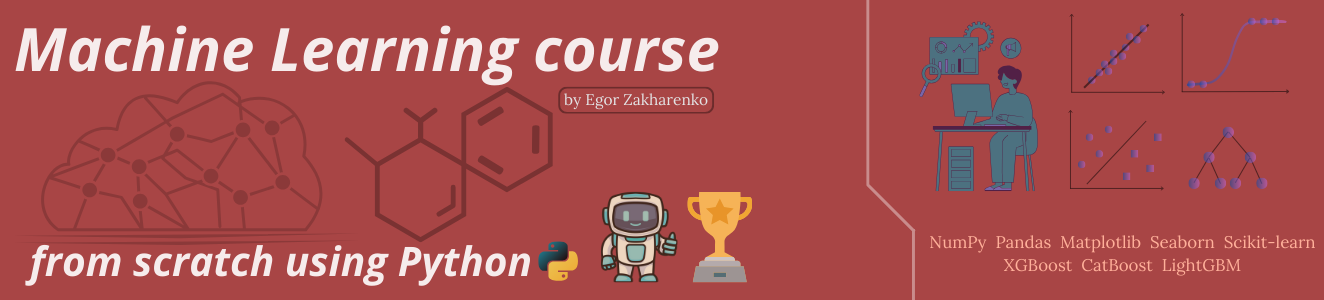

# 🏆**Principal Component Analysis (PCA). The main idea and implementation from scratch using Python**
Principal Component Analysis or PCA is an unsupervised learning algorithm used to reduce the dimension and identify the most informative features in the data. Its essence lies in the assumption of the linearity of data relations and their projection onto a subspace of orthogonal vectors in which the variance will be maximal. Such vectors are called the main components and they determine directions of the greatest variability (informativeness) of the data. Alternatively, the essence of PCA can be defined as a linear projection that minimizes the RMS distance between the source points and their projections.

### <span style="color:darkred">***Some useful links before we start***</span> 

- Tutorials in the same format with other popular algorithms you can find [**here**](https://www.kaggle.com/code/egazakharenko/all-popular-ml-algorithms-from-scratch-in-python)

- You can also download [**this notebook on GitHub**](https://github.com/egaoharu-kensei/ML-algorithms-from-scratch.-Course-for-beginners/blob/14af844258cb99d04d03c5fc23df40421edb2681/Notebooks%20%5Beng%5D/ML-algorithms%20from%20scratch/12%29%20Principal%20Component%20Analysis%20%28PCA%29.ipynb)

# **The principle of operation of PCA**
Initially, the feature matrix is necessarily centered so that the first main component can correspond to the direction of maximum variation of the data and not just their average value. Usually, finding the main components comes down to two main methods:
 - **Calculation of eigenvectors and eigenvalues of the covariance matrix of data**. Since the covariance matrix reflects the degree of linear relationship between different variables, the eigenvectors of this matrix will set the directions along which the data variance is maximum, and the eigenvalues will set the magnitude of this variance. The eigenvalue corresponding to the eigenvector characterizes the contribution of this vector to the explanation of the variance of the data and the greater the eigenvalue, the more significant the main component. Usually, only those main components are selected that explain a given level of variance, for example, 95%.

 - **Calculation of the singular value decomposition of the data matrix**. Singular value decomposition is a way of representing any matrix as a product of three other matrices: the left singular matrix U, the diagonal matrix of singular values S, and the right singular matrix V, where the singular values are the square roots of the eigenvalues of the covariance matrix of the data (this is what data pre-centering is done for in this case), the right singular matrix V it will correspond to the eigenvectors of the covariance matrix of the data, and the left U will be the projection of the original data onto the main components defined by the matrix V. Thus, the singular value decomposition also makes it possible to isolate the main components, but without the need to calculate the covariance matrix. Besides the fact that such a solution is more efficient, it is considered more numerically stable, since it does not require calculating the covariance matrix directly which may be poorly conditioned in the case of a strong correlation of features. Particularly this approach is used in the implementation of scikit-learn, but with some of the features discussed below.

**SVD-based PCA is constructed as follows:**
- 1) data centering occurs first and the number of components is determined at least between the number of samples and features if the number of components has not been specified;
- 2) Next, SVD is applied to the centered data matrix;
- 3) the svd_flip_vector method is applied to the matrix U which finds the maximum modulo elements in each column of the matrix U, extracts their signs and multiplies the matrix U by these signs to guarantee a deterministic output;
- 4) the explained variance for each principal component is calculated as squared corresponding singular values divided by n_samples - 1 and the transformed data is calculated taking into account the number of principal components according to the rule

$$X_{new} = X \cdot V = U \cdot S \cdot V^T \cdot V = U \cdot S$$

# **Additional features of PCA**
**The coefficient of explained variance** of each main component, available through the variable *explained_variance_ratio_*, indicates the proportion of variance of the dataset lying along the axis of each main component.

**Data recovery** using the *inverse_transform()* method consists in applying the inverse transformation of the PCA projection of the form $X_{recovered} = X_{d-proj} W_d^T$, where $W_d^T$ is a matrix of the first d principal components. It follows that the data will be recovered with losses proportional to the amount of discarded variance of the original data and the average square of the distance between the original and restored data represents a *reconstruction error*.

**Incremental PCA**, implemented as the [*IncrementalPCA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA) class, allows you to work more efficiently with large datasets by splitting them into mini-packages and storing them in memory piece by piece during training.

**Randomized PCA**, set using the svd_solver='randomized' parameter, uses a stochastic algorithm to quickly calculate approximate d principal components and it is based on the assumption that a random projection of data onto a low-dimensional subspace can preserve their structure and properties well, however, this approach may be less accurate.

**Kernel PCA**, implemented using the [*KernelPCA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) class, allows you to perform complex non-linear projections using kernel functions. As in the case of SVM, its essence in this case is that the linear boundary of solutions in a multidimensional feature space will correspond to a complex non-linear boundary in the original space.

# **Alternatives to PCA**
Despite the fact that the principal component method is one of the most popular dimensionality reduction algorithms there are alternatives that may be more preferable in a number of situations, as well as depending on the type of data:
- **LLE (Locally Linear Embedding)** is an algorithm for creating linear combinations of each point from its neighbors, followed by restoring these combinations in a lower dimensional space which allows you to preserve the nonlinear geometry of the data and be useful for some tasks where global properties are less important. On the other hand, this approach has high computational complexity and may be sensitive to noise.
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)** is an algorithm that converts similarities between data into probabilities and further tries to minimize the discrepancy between probability distributions in high and low dimensional space. t-SNE is effective in visualizing high-dimensional data, but it can distort the global data structure because it does not take into account linear dependencies, but only their proximity in the original space.
- **UMAP (Uniform Manifold Approximation and Projection)** is another algorithm suitable for data visualization which is based on the idea that the data lies on some homogeneous manifold that can be approximated using a neighbor graph. This approach takes into account the global data structure and allows for better adaptation to different types of data and better handling of noise and outliers than t-SNE.
- **Autoencoders** is a type of neural networks based on training the encoder to convert input data into a low-dimensional representation, followed by training the decoder to restore the original data from this representation. Autoencoders can also be used for data compression, noise removal, and many other purposes.

# **Python implementation from scratch**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
class SVDPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    @staticmethod
    def svd_flip_vector(U):
        max_abs_cols_U = np.argmax(np.abs(U), axis=0)
        # extract the signs of the max absolute values
        signs_U = np.sign(U[max_abs_cols_U, range(U.shape[1])])

        return U * signs_U

    def fit_transform(self, X):
        n_samples, n_features = X.shape
        X_centered = X - X.mean(axis=0)

        if self.n_components is None:
            self.n_components = min(n_samples, n_features)

        U, S, Vt = np.linalg.svd(X_centered)
        # flip the eigenvector sign to enforce deterministic output
        U_flipped = self.svd_flip_vector(U)

        self.explained_variance = (S[:self.n_components] ** 2) / (n_samples - 1)
        self.explained_variance_ratio = self.explained_variance / np.sum(self.explained_variance)

        # X_new = X * V = U * S * Vt * V = U * S
        X_transformed = U_flipped[:, : self.n_components] * S[: self.n_components]

        return X_transformed

### **Uploading a dataset**

In [ ]:
df_path = "/kaggle/input/iris-flower-dataset/IRIS.csv"
iris_df = pd.read_csv(df_path)
X, y = iris_df.iloc[:, :-1], iris_df.iloc[:, -1]
y = pd.Series(LabelEncoder().fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(iris_df)

# **Model training and evaluation of the obtained results**
The manual implementation showed identical scikit-learn results. As you can see, the first 2 main components explain almost 98% of the variance in the data which allows you to reduce the number of features by half without much loss of information. If the number of features were not 4 but several thousand or millions, then this would significantly reduce the training time of models without significant loss of accuracy (and sometimes with increased accuracy by reducing multicollinearity between features) what makes PCA and its alternatives an excellent addition to other algorithms.

**PCA**

In [ ]:
pca = SVDPCA()
X_transformed = pca.fit_transform(X)

print('transformed data', X_transformed[:10], '', sep='\n')
print('explained_variance', pca.explained_variance)
print('explained_variance_ratio', pca.explained_variance_ratio)

**PCA (scikit-learn)**

In [ ]:
sk_pca = PCA()
sk_X_transformed = sk_pca.fit_transform(X)

print('sk transformed data', sk_X_transformed[:10], '', sep='\n')
print('sk explained_variance', sk_pca.explained_variance_)
print('sk explained_variance_ratio_', sk_pca.explained_variance_ratio_)

# **Pros and cons**
Pros:
- reducing the dimension while preserving a large amount of information which also allows you to visualize high-dimensional data in two-dimensional or three-dimensional space;
- not only allows you to significantly speed up training, but also reduce the overfitting of models in some cases;
- can be used to compress data.

Cons:
- the inevitable loss of some information in the data;
- search only for linear dependence in the data (in the classic PCA);
- the lack of semantic meaning of the main components due to the difficulty of linking them with real features.

# **Additional sources**
Papers:
- «A Tutorial on Principal Component Analysis», Jonathon Shlens;
- «Locally Linear Embedding and its Variants: Tutorial and Survey», Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley;
- «Theoretical Foundations of t-SNE for Visualizing High-Dimensional Clustered Data», T. Tony Cai, Rong Ma;
- «UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction», Leland McInnes, John Healy, James Melville;
- «Deep Autoencoders for Dimensionality Reduction of High-Content Screening Data», Lee Zamparo, Zhaolei Zhang.

Documentation:
- [PCA description](https://scikit-learn.org/stable/modules/decomposition.html#pca);
- [LLE description](https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding);
- [t-SNE description](https://scikit-learn.org/stable/modules/manifold.html#t-sne);
- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html);
- [LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html);
- [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html);
- [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html).

Видео:
- PCA: [one](https://www.youtube.com/watch?v=FgakZw6K1QQ), [two](https://www.youtube.com/watch?v=fkf4IBRSeEc), [three](https://www.youtube.com/watch?v=IwPzjlBXBlA), [four](https://www.youtube.com/watch?v=WW3ZJHPwvyg);
- [LLE](https://www.youtube.com/watch?v=B6kzA1W_4pU);
- [t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM);
- [UMAP](https://www.youtube.com/watch?v=eN0wFzBA4Sc);
- [autoencoders](https://www.youtube.com/watch?v=FhmpO73ythg).